# Task 4 - Detection of face mask

## Problem Statement : Implement real time face mask detector
- Maintained By: **Ajinkya Jadhav**

### Reference :
- Big thanks to **Adrian Rosebrock** explaining how to implement computer vision model practically. 🙏🙏
- I have learned to implement this CV model from his tutorial.

### Import required libraries

In [39]:
# load the required library
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')
import imutils
from imutils import paths

In [2]:
# load the required library
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import time
import cv2

### Loading the images and Preprocessing it

In [45]:
img_path = os.path.sep.join([os.getcwd(),'dataset'])

In [46]:
# Initialize the initial learning rate, number of epochs to train for and the batch size
init_lr = 1e-4
epochs = 20
batch_size = 32

In [47]:
# load the list of the images
print("Loading the image...")
#join base_path and training img_path
image_paths = list(paths.list_images(img_path)) 
data = []
labels = []

# loop over the image paths
for imagePath in image_paths:
    # extract the class label from path
    label = imagePath.split(os.path.sep)[-2]
    
    # laod the input image and preprocess it 
    image = load_img(imagePath, target_size = (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    # store in the data and labels list
    data.append(image)
    labels.append(label)

 # convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

Loading the image...


In [48]:
# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# split the data into training and testing 
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, 
                                                  stratify=labels, random_state=42)

# Construct the training image generator for data image augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, 
                         width_shift_range=0.2, height_shift_range=0.2,
                         shear_range=0.15, horizontal_flip=True, 
                         fill_mode="nearest")


### Model Building

In [49]:
# Load the MobileNetV2 network, removing the fully connected layers
baseModel = MobileNetV2(weights="imagenet", include_top=False, 
                        input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model that will be placed on top of the base model
top_layer = baseModel.output
top_layer = AveragePooling2D(pool_size=(7, 7))(top_layer)
top_layer = Flatten(name="flatten")(top_layer)
top_layer = Dense(128, activation="relu")(top_layer)
top_layer = Dropout(0.5)(top_layer)
top_layer = Dense(2, activation="softmax")(top_layer)

# Place the top_layer on top of the base model
model = Model(inputs=baseModel.input, outputs=top_layer)

# Loop over all layers in the base model and 
# freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [50]:
# Compile the data model
print("Compiling the data model...")
opt = Adam(lr=init_lr, decay=init_lr/ epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

Compiling the data model...


In [51]:
# summary 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

__________________________________________________________________________________________________
block_15_add (Add)              (None, 7, 7, 160)    0           block_14_add[0][0]               
                                                                 block_15_project_BN[0][0]        
__________________________________________________________________________________________________
block_16_expand (Conv2D)        (None, 7, 7, 960)    153600      block_15_add[0][0]               
__________________________________________________________________________________________________
block_16_expand_BN (BatchNormal (None, 7, 7, 960)    3840        block_16_expand[0][0]            
__________________________________________________________________________________________________
block_16_expand_relu (ReLU)     (None, 7, 7, 960)    0           block_16_expand_BN[0][0]         
__________________________________________________________________________________________________
block_16_d

In [26]:
# Train the head of the network
print(" Training the last layer of the network...")
history = model.fit(aug.flow(trainX, trainY, batch_size= batch_size), 
              steps_per_epoch=len(trainX) // batch_size,
              validation_data=(testX, testY), 
              validation_steps=len(testX) // batch_size, 
              epochs=epochs)

 Training the last layer of the network...
Epoch 1/20
34/34 [==============================] - 76s 2s/step - loss: 0.6882 - accuracy: 0.6660 - val_loss: 0.2332 - val_accuracy: 0.9674
Epoch 2/20
34/34 [==============================] - 58s 2s/step - loss: 0.2500 - accuracy: 0.9566 - val_loss: 0.1150 - val_accuracy: 0.9891
Epoch 3/20
34/34 [==============================] - 59s 2s/step - loss: 0.1230 - accuracy: 0.9853 - val_loss: 0.0739 - val_accuracy: 0.9891
Epoch 4/20
34/34 [==============================] - 64s 2s/step - loss: 0.0918 - accuracy: 0.9896 - val_loss: 0.0573 - val_accuracy: 0.9891
Epoch 5/20
34/34 [==============================] - 69s 2s/step - loss: 0.0672 - accuracy: 0.9862 - val_loss: 0.0443 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 64s 2s/step - loss: 0.0559 - accuracy: 0.9884 - val_loss: 0.0369 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 68s 2s/step - loss: 0.0447 - accuracy: 0.9976 - val_loss: 0.0318 

In [27]:
# Make predictions on the testing set
print("Evaluating the network...")
predIdxs = model.predict(testX, batch_size=batch_size)

# For each image in the testing set, find the index of the label 
# with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# Show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# Save the model to disk
print("Saving mask detector model into disk...")
model.save('facemask_detector.model', save_format="h5")

Evaluating the network...
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       138
without_mask       0.99      0.99      0.99       138

   micro avg       0.99      0.99      0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276

Saving mask detector model into disk...


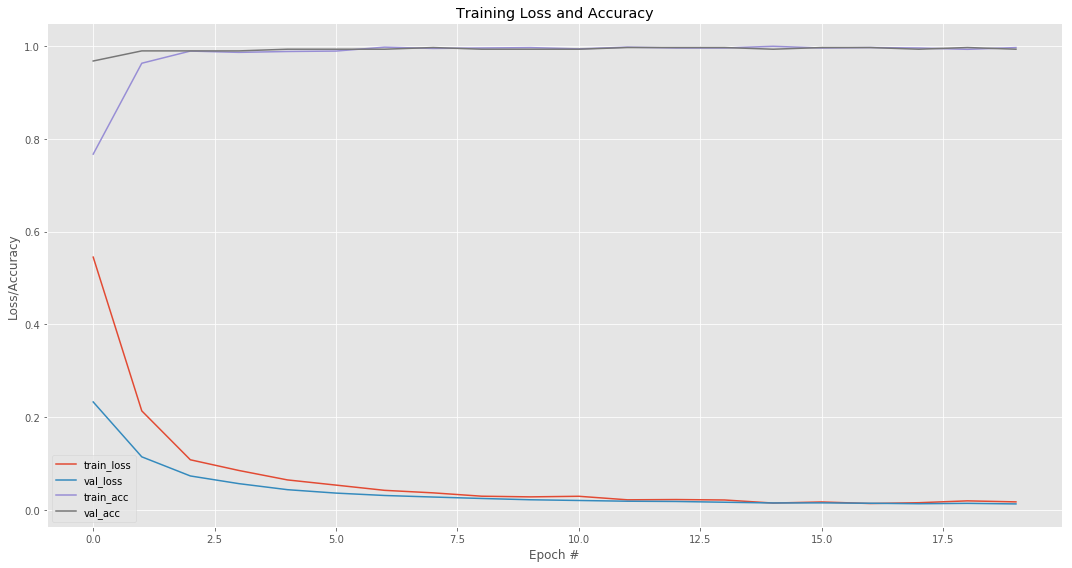

In [28]:
# Plot the training loss and accuracy
plt.figure(figsize=(15,8))
N = epochs
plt.style.use("ggplot")
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig('model_training_history.png')

### Evaluating model on the image

In [11]:
base_path = os.getcwd()
config_path = os.path.sep.join([base_path, 'model_config_'])
model_path = os.path.sep.join([base_path, 'facemask_detector.model'])

In [12]:
# Load the face detector model 
print("Loading the face detector model...")
prototxtPath = os.path.sep.join([config_path, "deploy.prototxt"])
weightsPath = os.path.sep.join([config_path, "res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# Load the face mask detector model
print("Loading the face mask detector model...")
model = load_model(model_path)

Loading the face detector model...
Loading the face mask detector model...


In [34]:
image_path = os.path.sep.join([base_path, 'examples', 'images (1).jpg'])
# Load the input image from disk, make a copy of it and 
#grab the image spatial dimensions
image = cv2.imread(image_path)
orig = image.copy()
(h, w) = image.shape[:2]

# Construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

# Pass the blob through the network and obtain the face detections
print(" Computing the face detections...")
net.setInput(blob)
detections = net.forward()

 Computing the face detections...


In [32]:
print("Image without mask:")
print(detections[0, 0, 0 ,0:3])

Image without mask:
[0.         1.         0.99923694]


7 [img_id, is_face, prob, x, y, w, h]

In [7]:
# Loop over the detections
for i in range(0, detections.shape[2]):
    # Extract the confidence (i.e, probability) associated with the detection
    confidence = detections[0, 0, i, 2]
    # Filter out weak detections by ensuring the confidence is greater than the minimum confidence
    if confidence > 0.5:
        # Compute the (x,y) coordinates of the bounding box for the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        # Ensure the bounding boxes fall within the dimensions of the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        # Extract the face ROI
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB) #convert it from BGR to RGB channel ordering
        face = cv2.resize(face, (224, 224)) #resize it to 224x224
        face = img_to_array(face)
        face = preprocess_input(face) # preprocess it
        face = np.expand_dims(face, axis=0) # insert a new at 0th position
        # Pass the face through the model to determine if the face has a mask or not
        (mask, withoutMask) = model.predict(face)[0]
        # Determine the class label and color that will be used to draw the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        # Include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        # Display the label and bounding box rectangle on the output frame
        cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# Show the output image
cv2.imshow("Output Image", image)
cv2.waitKey(0)

-1

### Evaluating a model on video stream

In [36]:
def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
                                 (104.0, 177.0, 123.0))
    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]
        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        faces=np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop

        # return a 2-tuple of the face locations and their corresponding
        # locations
    return (locs, preds)

In [37]:
# load our serialized face detector model from disk
print("Loading face detector model...")
prototxtPath = os.path.sep.join([config_path, "deploy.prototxt"])
weightsPath = os.path.sep.join([config_path,"res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
# load the face mask detector model from disk
print("Loading face mask detector model...")
maskNet = load_model(model_path)

Loading face detector model...
Loading face mask detector model...


In [41]:
# initialize the video stream and allow the camera sensor to warm up
print("Starting video stream...")
#vs = VideoStream(src=0).start()
vs = cv2.VideoCapture(0)
time.sleep(2.0)
# loop over the frames from the video stream
while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    #frame = vs.read()
    ret,frame = vs.read()
    # Our operations on the frame come here
    #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = imutils.resize(frame, width=400)
    # detect faces in the frame and determine if they are wearing a
    # face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
    # loop over the detected face locations and their corresponding
    # locations
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred
        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
    # show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
    
# do a bit of cleanup
# When everything done, release the capture
vs.release()
cv2.destroyAllWindows()
#vs.stop()

Starting video stream...
